# Create a dataframe for the 2k IMPACT dataset

TO DO

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 43
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [3]:
folder = os.path.join(os.environ['HOME'],"surfdrive/Shared/OCR")

# data folders
ocr_original_folder = "Original ALTO files " # ABBY 8
ocr_new_folder = "ReOCRed (FR11)" # ABBY 11
ground_folder = "Reordered Ground-truth"

##### TODO

* Parallelize
* Extend to other datasets

In [4]:
# function to read a file and get original filename, tokens and their confidence out of an alto xml file

def get_contents(soup):
    filename = soup.find("filename").text
    # find all strings (== tokens) and get text plus word-level confidence
    word_level_confidence = list()
    text = list()
    for match in soup.findAll("string"):
        word_level_confidence.append(float(match["wc"]))
        text.append(match["content"])
    return filename, text, word_level_confidence

In [5]:
LIMIT = 3000

In [6]:
# LOAD ground truth

data_dict = {'filename':list(),'text_ground':list()}

# load xml files and get data out
for root, dirnames, filenames in os.walk(os.path.join(folder,ground_folder)):
    for f in tqdm(filenames[:LIMIT]):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"))
            filename, text, word_level_confidence = get_contents(soup)
            data_dict['filename'].append(filename)
            data_dict['text_ground'].append(text)

100%|██████████| 2000/2000 [14:22<00:00,  2.32it/s]


In [7]:
df_ground = pd.DataFrame.from_dict(data_dict)
df_ground = df_ground.set_index('filename')

In [8]:
df_ground.head()

,text_ground
filename,
DDD_010197037_001.jp2,"[No., 9922., Tweede, Blad., Vrijdag, 29, Juli,..."
DDD_011219339_001.jp2,"[De, Surinamer, Redactie, J., WILLEBRANDS, Dag..."
DDD_011179281_001.jp2,"[DE, GRONDWET., Mrs., L., Mulder,, Uitgeefster..."
DDD_010948945_001.jp2,"[Het, Vrije, Volk, Maandag, 25, augustus, 1986..."
MMGARO01_000177181_002_master.jp2,"[De, troepen, vertrokken, 8, en, 9, Sept,, uit..."


In [9]:
# LOAD OCR texts

data_dict_ocr_1 = {'filename':list(),'text_ocr':list(),'word_level_confidence_ocr':list()}
data_dict_ocr_2 = {'filename':list(),'text_reocr':list(),'word_level_confidence_reocr':list()}

# load xml files and get data out
for root, dirnames, filenames in os.walk(os.path.join(folder,ocr_original_folder)):
    for f in tqdm(filenames[:LIMIT]):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"))
            filename, text, word_level_confidence = get_contents(soup)
            data_dict_ocr_1['filename'].append(filename)
            data_dict_ocr_1['word_level_confidence_ocr'].append(word_level_confidence)
            data_dict_ocr_1['text_ocr'].append(text)
for root, dirnames, filenames in os.walk(os.path.join(folder,ocr_new_folder)):
    for f in tqdm(filenames[:LIMIT]):
        if ".xml" in f:
            full_path = os.path.join(root,f)
            soup = BeautifulSoup(codecs.open(full_path,encoding="utf8"))
            filename, text, word_level_confidence = get_contents(soup)
            data_dict_ocr_2['filename'].append(filename)
            data_dict_ocr_2['word_level_confidence_reocr'].append(word_level_confidence)
            data_dict_ocr_2['text_reocr'].append(text)

100%|██████████| 2000/2000 [25:21<00:00,  1.31it/s]


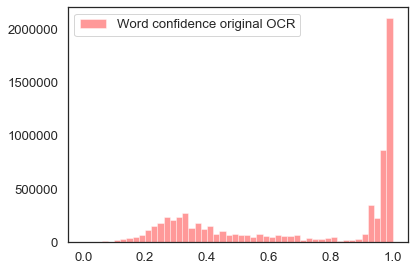

In [10]:
flatten = lambda l: [item for sublist in l for item in sublist]
l = flatten(data_dict_ocr_1['word_level_confidence_ocr'])
sns.distplot(l, label="Word confidence original OCR", kde=False, color="red")
plt.legend()
plt.tight_layout()

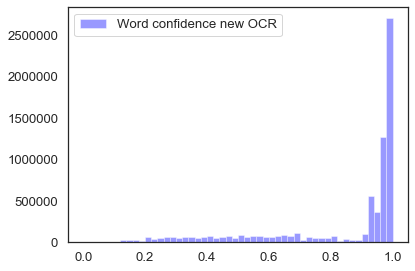

In [11]:
#l = flatten(data_dict_ocr_1['word_level_confidence_ocr'])
#sns.distplot(l, label="Word confidence original OCR", kde=False, color="red")
l2 = flatten(data_dict_ocr_2['word_level_confidence_reocr'])
sns.distplot(l2, label="Word confidence new OCR", kde=False, color="blue")
plt.legend()
plt.tight_layout()

In [12]:
df_ocr = pd.DataFrame.from_dict(data_dict_ocr_1)
df_ocr = df_ocr.set_index('filename')
df_reocr = pd.DataFrame.from_dict(data_dict_ocr_2)
df_reocr = df_reocr.set_index('filename')

In [13]:
df_ocr.head()

,text_ocr,word_level_confidence_ocr
filename,,
DDD_010033326_001.jp2,"[NIEUWE, ROTTERDAMSCHE, COURANT., », «.<.»«««,...","[0.98, 0.96, 0.98, 0.98, 0.96, 0.98, 0.96, 1.0..."
DDD_010541077_002.jp2,"[Kolom, Links, mensen, ♦, De, acteur, Edward, ...","[0.96, 0.96, 0.99, 0.2, 0.39, 0.99, 0.91, 0.97..."
MMDA03_000114653_002_master.jp2,"[SPORTNIEUWS, Drentsche, Voetbalbond., OFFICIE...","[0.3, 0.24, 0.31, 0.32, 0.34, 0.33, 0.38, 0.22..."
MMKB08_000166020_002_master.jp2,"[Verder, behandelt, de, Resolutie, technisch,,...","[0.4, 0.22, 0.26, 0.29, 0.3, 0.23, 0.24, 0.36,..."
DDD_010219949_001.jp2,"[Dit, nummer, bestaat, uit, vier, bladen, Eers...","[0.96, 1.0, 0.98, 0.97, 0.97, 0.96, 0.99, 0.26..."


In [14]:
df_reocr.head()

,text_reocr,word_level_confidence_reocr
filename,,
DDD_011218694_001.jp2,"[11, i, —in, >i, i, I—••, -, J, --, ■, ■, ■, D...","[0.9, 0.32, 0.9, 0.62, 0.24, 0.33, 0.37, 0.24,..."
MMSAB03_000062844_001_master.jp2,"[j\o,, 262., ,., DONDERDAG, 8, NOVEMBER, 1925....","[0.42, 0.68, 0.81, 0.97, 0.44, 0.97, 0.24, 0.1..."
MMGAVL01_000007154_001_master.jp2,"[nieuwe, lleniosche, courant, van, Zaterdag.29...","[0.97, 0.55, 0.98, 0.97, 0.99, 0.4, 0.59, 0.97..."
DDD_010189794_002.jp2,"[blikevnen, die, een, soort, van, voogdij, «Ve...","[0.3, 0.93, 0.91, 0.96, 0.92, 0.96, 0.94, 0.92..."
DDD_010882847_002.jp2,"[die, terugkomst, van, de, bewoners, overvalle...","[0.96, 0.98, 0.93, 0.33, 0.98, 0.99, 0.93, 0.9..."


In [15]:
full_df = pd.concat([df_ground, df_ocr], join="inner", axis=1)
full_df = pd.concat([full_df, df_reocr], join="inner", axis=1)

In [16]:
full_df.shape

(2000, 5)

In [17]:
full_df.head()

,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr
filename,,,,,
DDD_010197037_001.jp2,"[No., 9922., Tweede, Blad., Vrijdag, 29, Juli,...","[JSo., 9822, xTweede, Blad., Vrijdag, 29, Juli...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","[ISO., 9922, -Tweede, Blad., ss*, Vrijdag, 29,...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9..."
DDD_011219339_001.jp2,"[De, Surinamer, Redactie, J., WILLEBRANDS, Dag...","[De, Surinamer, •v*, WILLEBRANDS:i^, Dagblad, ...","[0.96, 0.98, 0.46, 0.48, 0.99, 0.97, 0.99, 0.5...","[Whd^Mmumr, Redactie, J., WILLEBRANDS, Dagblad...","[0.25, 0.99, 0.83, 0.84, 0.98, 0.97, 0.99, 0.9..."
DDD_011179281_001.jp2,"[DE, GRONDWET., Mrs., L., Mulder,, Uitgeefster...","[DE, GRONDWET., Mrs., 3L.., Mulder,, TJitgêels...","[0.96, 0.98, 0.95, 0.52, 0.97, 0.41, 0.34, 0.9...","[DE, GRONDWET., Mrs., Xj., Melder,, Uitgeefste...","[0.76, 0.97, 0.5, 0.62, 0.97, 0.98, 0.97, 0.74..."
DDD_010948945_001.jp2,"[Het, Vrije, Volk, Maandag, 25, augustus, 1986...","[Het, Vrije, Volk, Maandag, 25, augustus, 1986...","[0.98, 0.98, 0.98, 1.0, 1.0, 0.98, 0.86, 0.63,...","[Ê, •, :>, %, V, f, A, i, *, %, iiiisy, V, -;,...","[0.27, 0.44, 0.14, 1.0, 0.13, 0.33, 1.0, 0.3, ..."
MMGARO01_000177181_002_master.jp2,"[De, troepen, vertrokken, 8, en, 9, Sept,, uit...","[De, tioepen, vertrokken, 8, en, 9, Sept., uit...","[0.59, 0.32, 0.32, 0.78, 0.07, 1.0, 0.25, 0.18...","[De, troepen, vertrokken, 8, en, 9, Sept., uit...","[0.5, 0.98, 0.99, 0.41, 0.46, 0.76, 0.61, 0.96..."


In [18]:
full_df["word_level_average_confidence_ocr"] = full_df["word_level_confidence_ocr"].apply(lambda x: np.average(x))
full_df["word_level_average_confidence_reocr"] = full_df["word_level_confidence_reocr"].apply(lambda x: np.average(x))

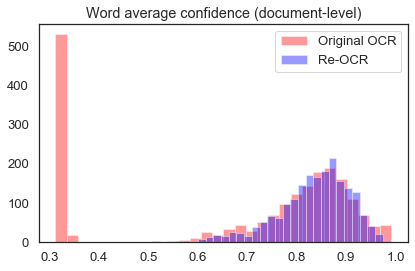

In [19]:
sns.distplot(full_df["word_level_average_confidence_ocr"].values, label="Original OCR", kde=False, color="red", bins=30)
sns.distplot(full_df["word_level_average_confidence_reocr"].values, label="Re-OCR", kde=False, color="blue", bins=30)
plt.title("Word average confidence (document-level)")
plt.legend()
plt.tight_layout()

In [20]:
full_df.to_csv("full_df.csv", compression="gzip")